In [83]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Activation,BatchNormalization
from keras import initializers
from tensorflow.keras.layers import InputSpec
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
from tensorflow.keras.layers import Layer
import tensorflow as tf
from keras.activations import sigmoid,elu
from tensorflow.keras.layers import LeakyReLU, PReLU
from keras import regularizers
import math
import warnings;warnings.filterwarnings(action='ignore')

In [4]:
image_size = 28
num_channels = 3
num_features = image_size * image_size * num_channels
num_classes = 10

num_train = 49000

## Load Data

In [85]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f'Train data shape: {X_train.shape}')
print(f'Test  data shape: {X_test.shape}')

Train data shape: (60000, 28, 28)
Test  data shape: (10000, 28, 28)


### Data Visualization

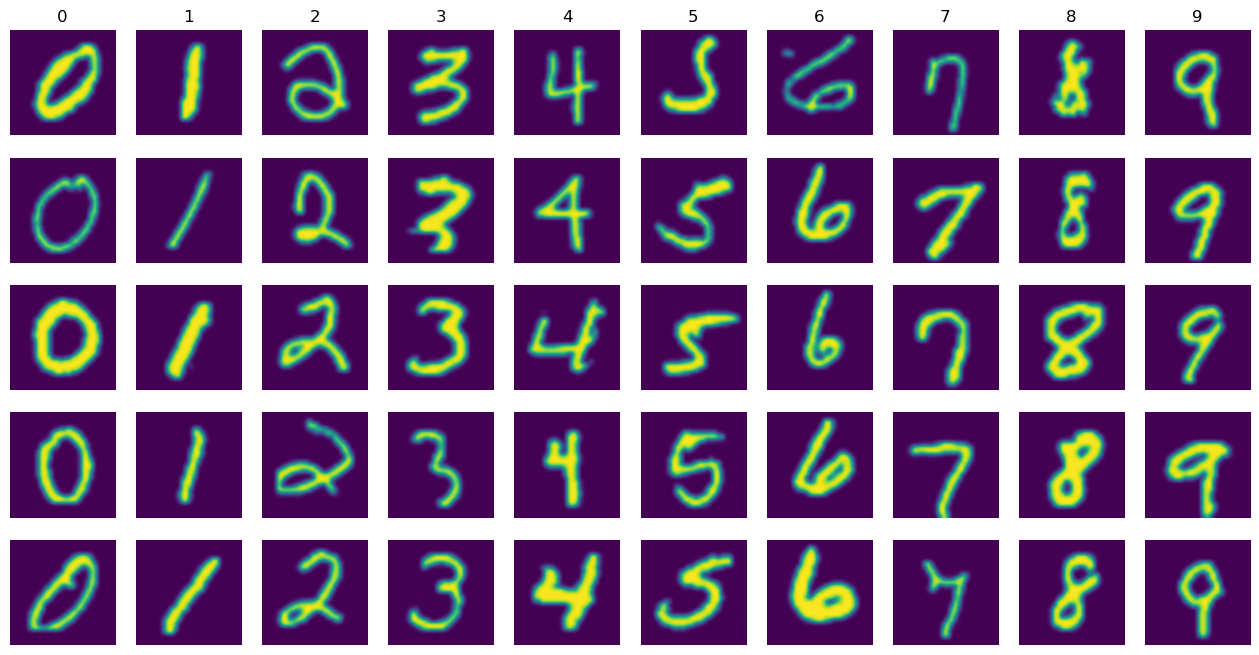

In [87]:
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
samples_per_class = 5

plt.figure(figsize=(16, 8))

for cls, name in enumerate(class_names):
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + cls + 1 # cls=0 -> (1, 11,...,61), cls=2 -> (2, 12,...,62),...,cls=9 ->(10, 20,...,70)
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx], interpolation='bicubic') # Interpolation used to smooth the appearance of plotted data
        plt.axis('off')
        if i == 0:
            plt.title(class_names[cls])

### Data Preprocessing

In [95]:
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### One-hot encodding

In [103]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


## Activation Function

### Parametric Rectified Sigmoid Exponential Linear Unit (RSigELU)

$$\
f(x) =
\begin{cases}
x \cdot \sigma(x) \cdot \alpha + x & \text{if } x > 1.0 \\
x & \text{if } 0 \leq x \leq 1.0 \\
\beta \cdot (\exp(x) - 1) & \text{if } x < 0
\end{cases}
\ $$

Explanation of Each Region

1. **Region 1 $ (x > 1.0) $**:
   - For inputs greater than 1, the function scales the input by a product of the sigmoid function and the learnable parameter $ \alpha $, and then adds the original input $x$.
   - This region smoothly adjusts the output based on both $x$ and $ \alpha $, allowing a flexible response that can adapt to the data during training.

2. **Region 2 $ (0 \leq x \leq 1.0) $**:
   - In this middle region, the function behaves linearly. The output is exactly the input $x$. This part of the function is continuous with no modifications, ensuring a smooth transition between the other two regions.

3. **Region 3 $ (x < 0) $**:
   - For negative inputs, the function behaves similarly to an Exponential Linear Unit (ELU) but scaled by $ \beta $.
   - The expression $ \exp(x) - 1 $ allows the output to be smooth and gradually approach zero as $x$ becomes more negative, with the scaling factor $ \beta $ providing a way to adjust this region’s sensitivity.

Significance of Parameters

- **$ \alpha $ and $ \beta $ as Learnable Parameters**:
  - These parameters are initialized using specific methods (e.g., GlorotNormal) but are adjusted during training to minimize the loss function.
  - **$ \alpha $** controls the slope for positive values greater than 1.
  - **$ \beta $** controls the slope for negative values less than 0.
  

In [117]:
learning_rate = 0.01
epochs = 50
batch_size = 32
num_classes = 10
weight_decay = 0.0005
class PPRsigELU(Layer):

    def __init__(self, alpha_initializer ='GlorotNormal',beta_initializer ='GlorotNormal', **kwargs):
        super(PPRsigELU, self).__init__(**kwargs)
        self.supports_masking = True
        
        self.alpha_initializer = initializers.get(alpha_initializer)
        self.beta_initializer = initializers.get(beta_initializer)

    def build(self, input_shape):
        self.alpha = self.add_weight(shape=[1], name='alpha', 
                                    initializer=self.alpha_initializer,
                                     )
        self.beta = self.add_weight(shape=[1], name='beta', 
                                    initializer=self.beta_initializer,
                                     )
        self.input_spec = InputSpec(ndim=len(input_shape))
        self.built = True

    def call(self, inputs): #get_output
        alpha = 0.5
        beta = 0.5
        #return tf.maximum(0.0,inputs) #RELU
        #return tf.where(inputs > 1.0,  inputs * K.sigmoid(inputs)*self.alpha +inputs, tf.where(inputs <= 0.0, self.alpha * (K.exp(inputs) - 1.0), inputs)) #This section presents single parametric RSigELU activation function. 
        #return tf.where(inputs > 1.0,  inputs * K.sigmoid(inputs)*self.alpha +inputs, tf.where(inputs <= 0.0, self.beta * (K.exp(inputs) - 1.0), inputs)) #This section presents double parametric RSigELU activation function. 
        #return tf.where(inputs > 1.0,  inputs * K.sigmoid(inputs)*alpha +inputs, tf.where(inputs <= 0.0, alpha * (K.exp(inputs) - 1.0), inputs)) #This section presents single  RSigELU activation function. 
        return tf.where(inputs > 1.0,
                    inputs * tf.nn.sigmoid(inputs) * alpha + inputs,
                    tf.where(inputs <= 0.0,
                             beta * (tf.exp(inputs) - 1.0),
                             inputs))
        
    def get_config(self):
        config = {
                  'alpha_initializer': initializers.serialize(self.alpha_initializer),
                  'beta_initializer': initializers.serialize(self.beta_initializer)}
        base_config = super(PPRsigELU, self).get_config()
        print("Alpha Degeri",self.alpha)
        print("Beta Degeri",self.beta)
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

## Create Model

In [120]:
def create_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',  input_shape=X_train.shape[1:]))
    model.add(Activation(PPRsigELU()))
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation(PPRsigELU()))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4)) 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(512))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [122]:
model = create_cnn()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 28, 28, 32)          │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 32)          │               2 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,489,262 (13.31 MB)

 Trainable params: 3,489,198 (13.31 MB)

 Non-trainable params: 64 (256.00 B)

## Train

In [124]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history=model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=40,
              shuffle=True)

Epoch 1/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 145s 77ms/step - accuracy: 0.8958 - loss: 0.3716
Epoch 2/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 138s 74ms/step - accuracy: 0.9721 - loss: 0.0921
Epoch 3/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 139s 74ms/step - accuracy: 0.9768 - loss: 0.0764
Epoch 4/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 75ms/step - accuracy: 0.9806 - loss: 0.0631
Epoch 5/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 132s 70ms/step - accuracy: 0.9830 - loss: 0.0542
Epoch 6/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 88s 47ms/step - accuracy: 0.9831 - loss: 0.0521
Epoch 7/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 75ms/step - accuracy: 0.9844 - loss: 0.0479
Epoch 8/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 142s 76ms/step - accuracy: 0.9855 - loss: 0.0458
Epoch 9/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 75ms/step - accuracy: 0.9858 - loss: 0.0433
Epoch 10/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 136s 73ms/step - accuracy: 0.9873 - loss: 0.0382
Epoch 11/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 117s 62ms/step - accuracy: 0.9877 - loss: 0.038

#### save model

In [126]:
model.save('model-P+RsigELU-Activation-Function.h5')

Alpha Degeri <KerasVariable shape=(1,), dtype=float32, path=sequential_3/activation_2/pp_rsig_elu_2/alpha>
Beta Degeri <KerasVariable shape=(1,), dtype=float32, path=sequential_3/activation_2/pp_rsig_elu_2/beta>
Alpha Degeri <KerasVariable shape=(1,), dtype=float32, path=sequential_3/activation_3/pp_rsig_elu_3/alpha>
Beta Degeri <KerasVariable shape=(1,), dtype=float32, path=sequential_3/activation_3/pp_rsig_elu_3/beta>


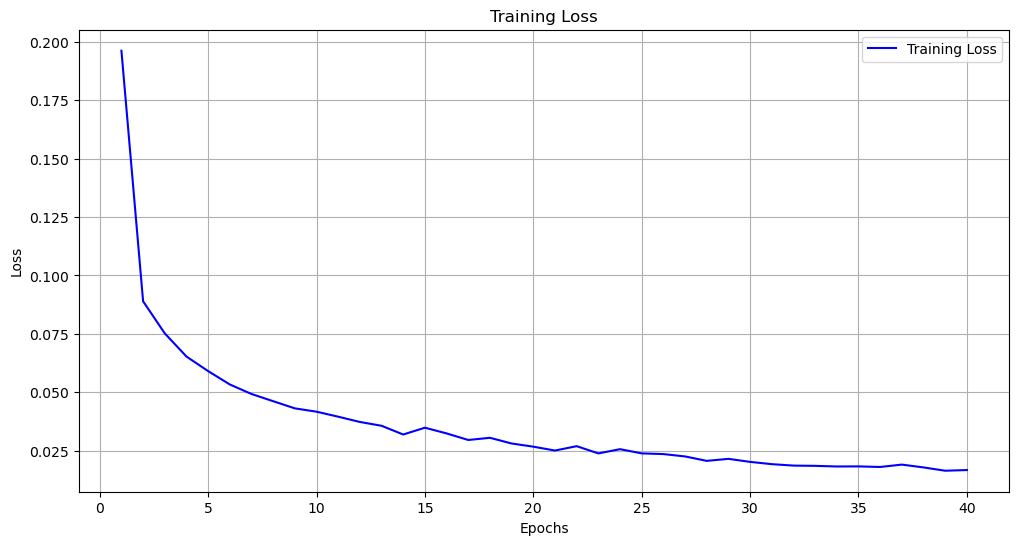

In [142]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

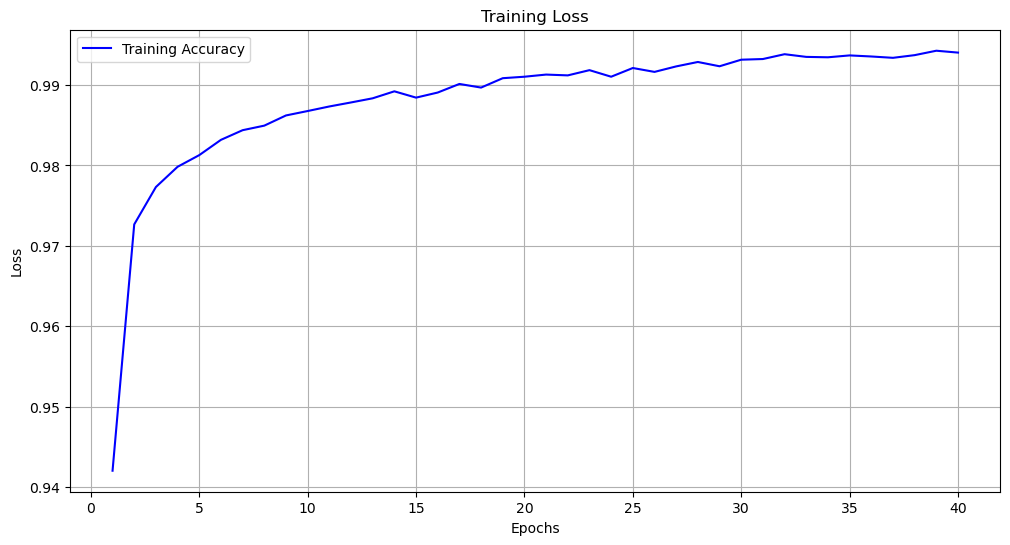

In [144]:
acc = history.history['accuracy']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [138]:
acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test loss:', acc[0])
print('Test accuracy:', acc[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9866 - loss: 0.0569
Test loss: 0.04715631157159805
Test accuracy: 0.9889000058174133


In [146]:
acc = model.evaluate(X_train, y_train, batch_size=batch_size)
print('Train loss:', acc[0])
print('Train accuracy:', acc[1])

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 28ms/step - accuracy: 0.9990 - loss: 0.0036
Train loss: 0.0035296871792525053
Train accuracy: 0.9990000128746033
